In [4]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [5]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [6]:
filename = "N-CMAPSS_DS01-005.h5"

In [7]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (7641868, 4)
X_s shape: (7641868, 14)
X_v shape: (7641868, 14)
T shape: (7641868, 10)
A shape: (7641868, 4)


In [8]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


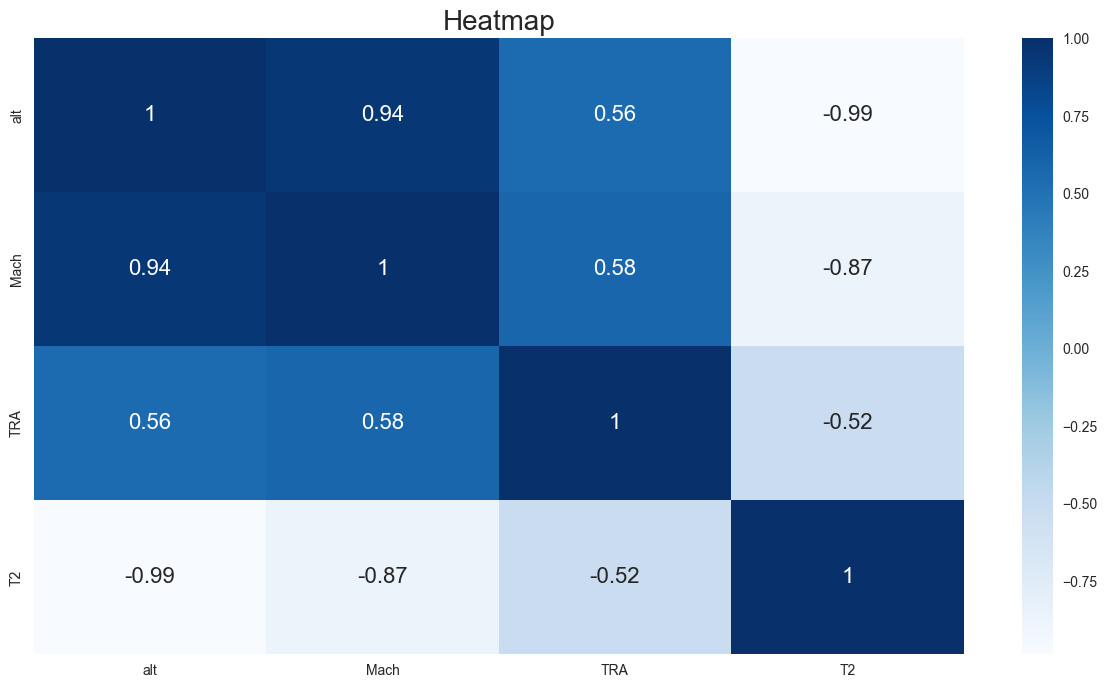

In [9]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [23]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,618.288596,1470.469798,1849.620676,1269.275585,19.432070,14.484611,19.727990,24.410990,394.701872,401.205188,15.974771,2142.253462,8693.176503,4.621622,1.0,3013.0,0.376362,70.311996,522.314770,1.0
1,618.296355,1470.415593,1849.519871,1269.177159,19.431385,14.484683,19.727295,24.410483,394.629899,401.132851,15.970518,2142.218596,8693.000298,4.620561,1.0,3020.0,0.376866,70.311996,522.327145,1.0
2,618.336514,1470.453853,1849.566139,1269.167353,19.435163,14.488224,19.731130,24.415476,394.667850,401.171401,15.969419,2142.257956,8693.106262,4.621064,1.0,3025.0,0.377685,70.311996,522.371840,1.0
3,618.302173,1470.650929,1850.195069,1269.518670,19.426003,14.477632,19.721830,24.406544,394.773533,401.272707,15.967762,2142.794673,8693.680367,4.624305,1.0,3035.0,0.376992,70.399887,522.282418,1.0
4,618.345228,1470.640421,1849.950988,1269.253972,19.427484,14.478114,19.723334,24.410159,394.732158,401.234620,15.962571,2143.015150,8693.714825,4.622768,1.0,3043.0,0.377622,70.399887,522.300605,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7641863,569.171314,1262.152711,1505.220656,1142.358688,16.327415,14.032529,16.576056,18.692318,225.954240,230.620941,14.255220,1596.571022,7985.475267,2.174156,10.0,3018.0,0.310653,26.367001,517.710478,82.0
7641864,569.152102,1262.138240,1505.152347,1142.334251,16.325787,14.030423,16.574404,18.690493,225.950147,230.617148,14.256880,1596.577489,7985.456042,2.173944,10.0,3014.0,0.309960,26.367001,517.681857,82.0
7641865,569.173286,1262.180290,1505.292305,1142.446055,16.329035,14.033521,16.577700,18.693991,225.991428,230.658479,14.259194,1596.552581,7985.560636,2.174648,10.0,3010.0,0.310149,26.367001,517.707243,82.0
7641866,569.178315,1262.202029,1505.274693,1142.442261,16.330290,14.034248,16.578975,18.695488,226.017333,230.685275,14.261579,1596.586737,7985.651661,2.174786,10.0,3005.0,0.309834,26.367001,517.706106,82.0


In [24]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 800x550 with 0 Axes>

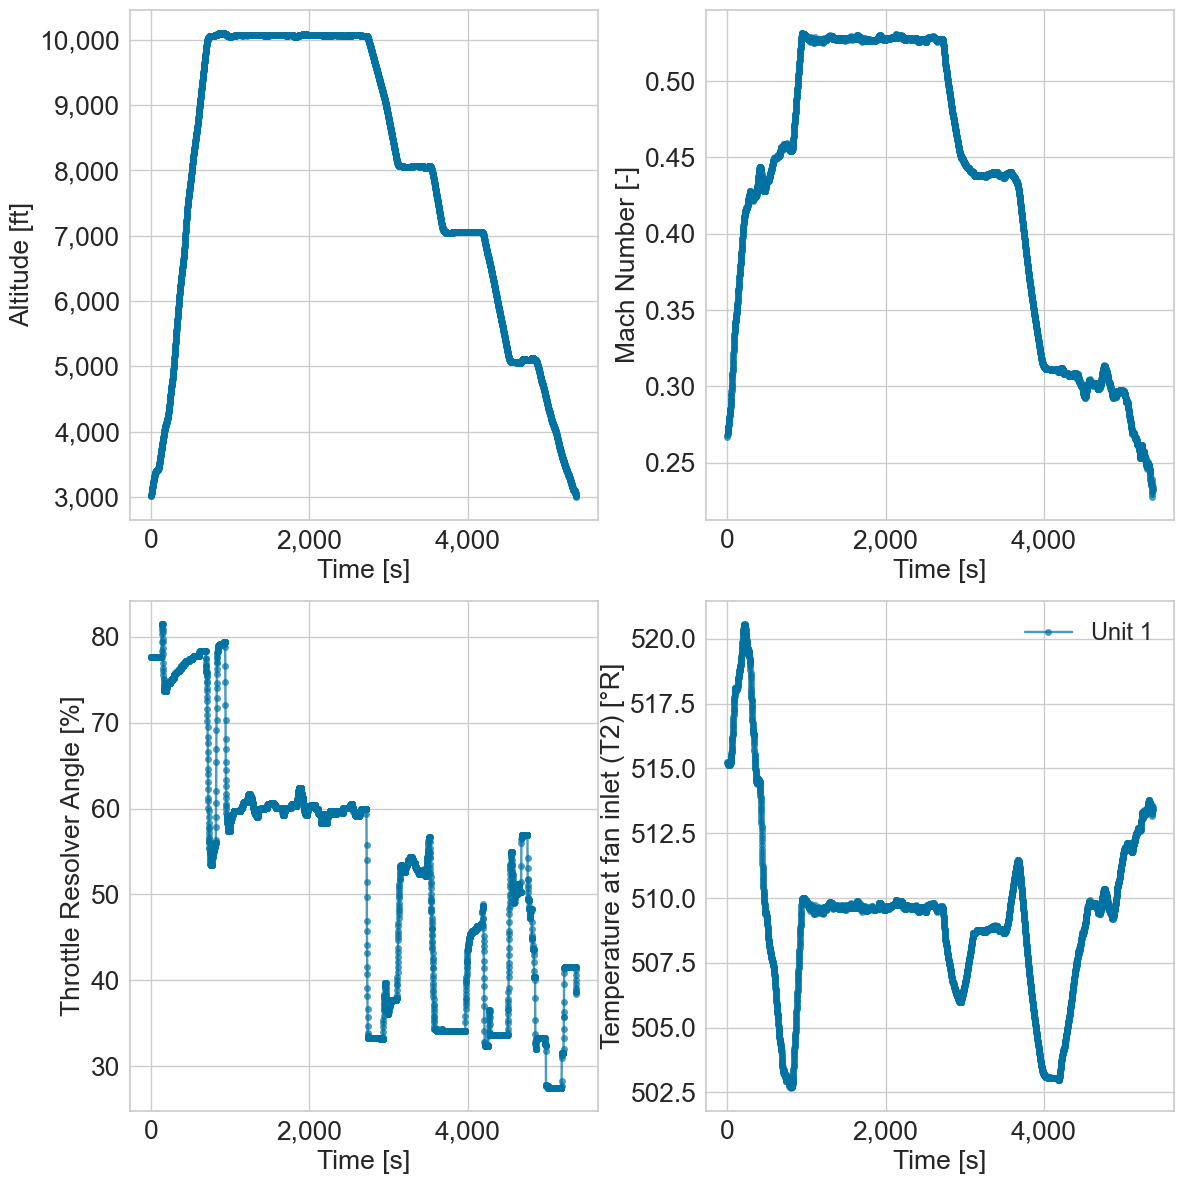

In [25]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [26]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True)

[    835     846     854 ... 7641612 7641619 7641623]


<Figure size 800x550 with 0 Axes>

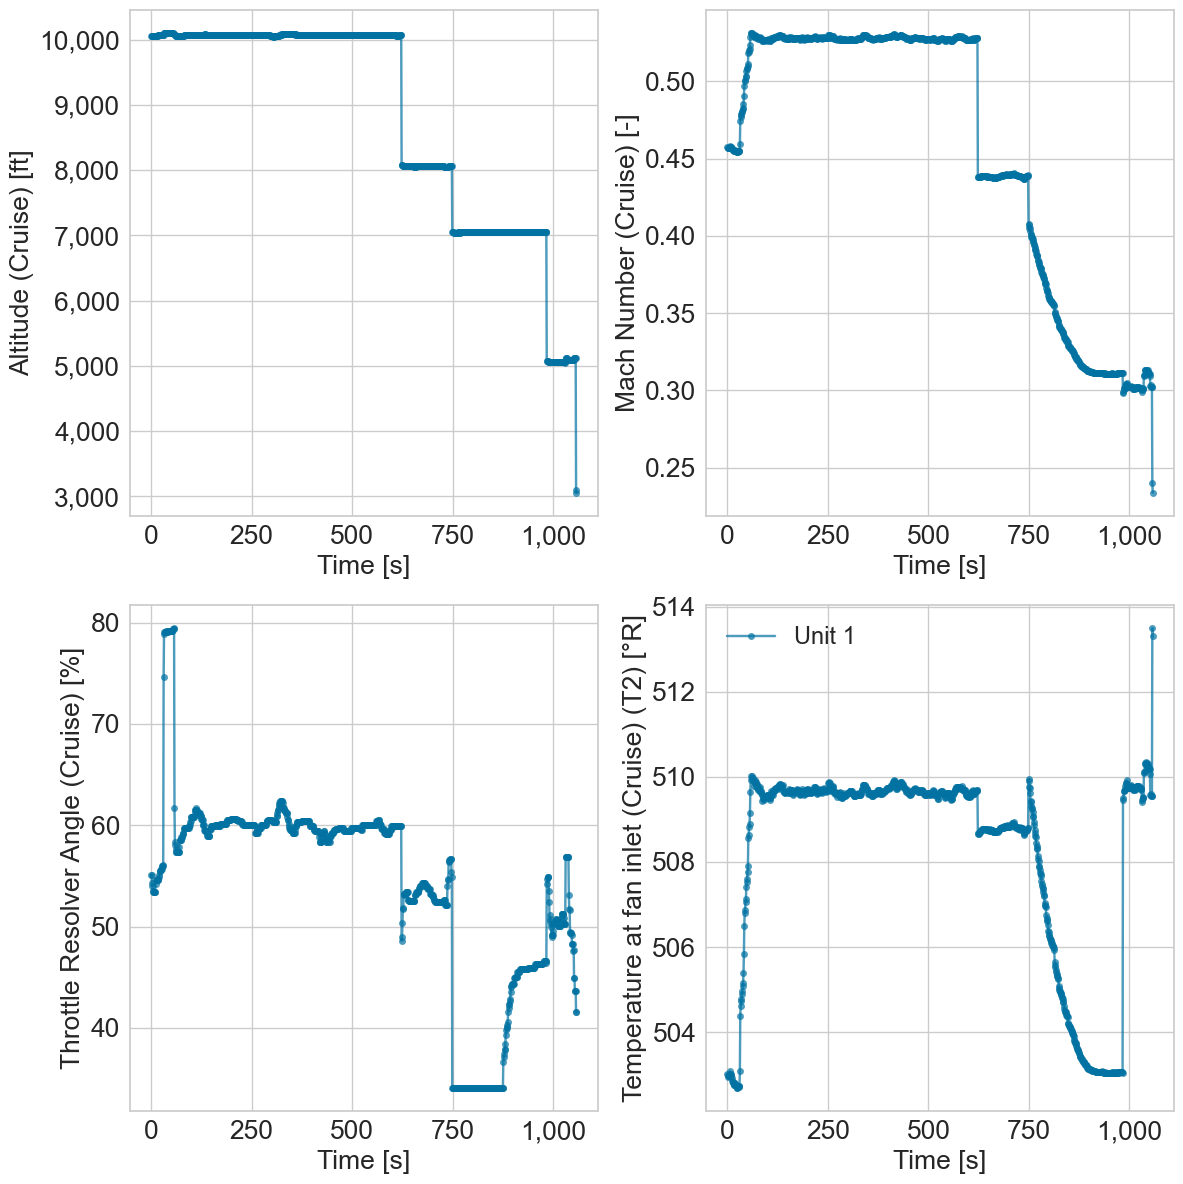

In [27]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

3.309109137039537e-15 1.0
(919634, 19)


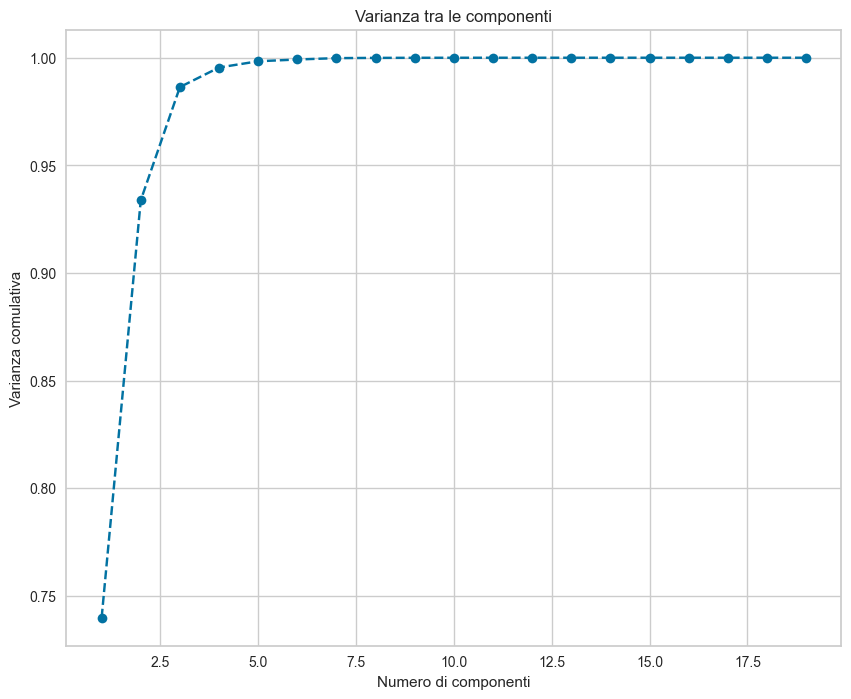

In [14]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

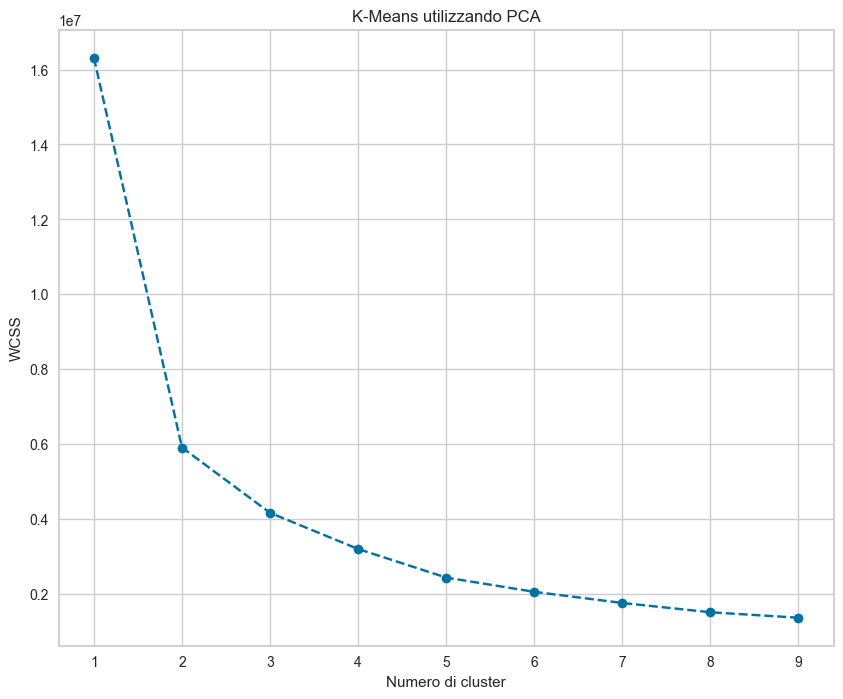

In [15]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

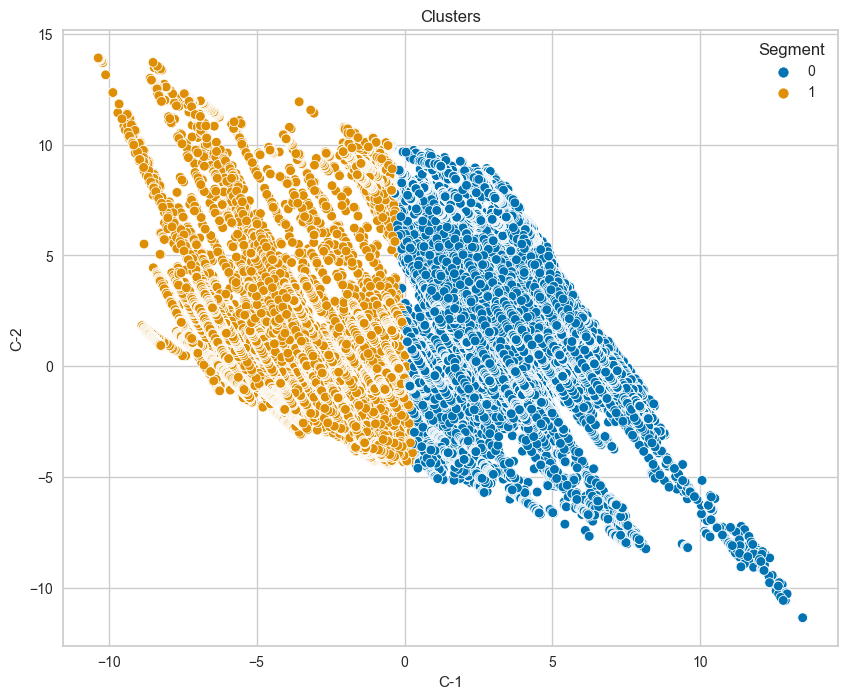

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,835,604.879374,1444.791411,1823.231700,1226.781171,16.110502,11.825509,16.355840,20.566123,335.320672,...,1.0,10471.0,0.509859,77.167419,506.352753,1.0,7.042637,-6.808017,0,0
1,846,606.173383,1448.216471,1828.776041,1229.215502,16.201676,11.873190,16.448402,20.710063,338.140429,...,1.0,10485.0,0.516537,77.782646,506.961661,1.0,7.200337,-7.042913,0,0
2,854,606.832019,1449.645919,1830.651114,1229.895271,16.252226,11.905501,16.499722,20.784766,339.347956,...,1.0,10492.0,0.520884,77.958427,507.368620,1.0,7.270810,-7.133492,0,0
3,860,605.361445,1441.030577,1811.106511,1218.768242,16.174659,11.927127,16.420973,20.621049,332.387137,...,1.0,10497.0,0.523782,75.673286,507.641208,1.0,6.911402,-6.467719,0,0
4,862,602.042145,1424.736293,1775.281503,1199.173623,15.990611,11.934432,16.234123,20.257418,319.504991,...,1.0,10498.0,0.524727,71.454567,507.731865,1.0,6.233680,-5.225441,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919629,7641606,567.155181,1256.669726,1497.073219,1134.613028,15.964173,13.741462,16.207282,18.284494,220.121728,...,10.0,3875.0,0.334467,26.367001,516.144697,82.0,3.019518,7.663787,0,0
919630,7641611,567.023711,1256.545633,1497.170112,1134.837189,15.952186,13.729059,16.195112,18.269523,220.047319,...,10.0,3868.0,0.331947,26.367001,516.002432,82.0,3.015246,7.670603,0,0
919631,7641612,567.065207,1256.599879,1497.266178,1134.867213,15.956390,13.733413,16.199380,18.274386,220.083562,...,10.0,3870.0,0.332766,26.367001,516.051529,82.0,3.018239,7.666548,0,0
919632,7641619,567.056069,1256.610746,1497.178803,1134.838819,15.956720,13.732835,16.199715,18.274917,220.110311,...,10.0,3860.0,0.331884,26.367001,516.028488,82.0,3.020354,7.668651,0,0


In [16]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [17]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-9.103859298311358e-16 0.999999999999999
(447609, 21)
-1.4382137195407476e-16 0.9999999999999998
(472025, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,3.716274e+06,580.150978,1347.256512,1651.114711,1153.355731,14.795215,11.685096,15.020522,18.049562,263.816748,...,1934.542809,8295.871481,2.799927,5.404572,10232.754297,0.464873,54.353967,503.674202,46.395131,0.0
mean,3.947919e+06,553.229473,1311.984390,1639.495373,1090.372170,9.761379,7.338695,9.910029,12.367885,191.991924,...,2039.024802,8184.555307,2.067802,5.759691,25115.507723,0.664533,72.265079,467.100942,42.323320,1.0


Text(0, 0.5, 'Flight Class # [-]')

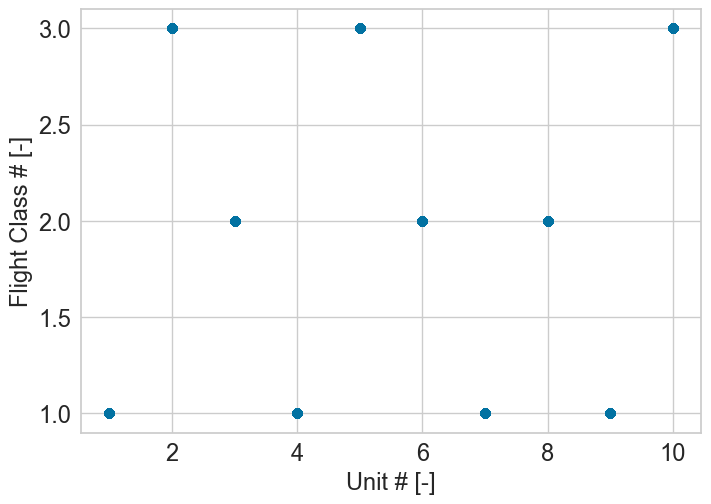

In [18]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [19]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 1, 2: 3, 3: 2, 4: 1, 5: 3, 6: 2, 7: 1, 8: 2, 9: 1, 10: 3}

In [20]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,835,604.879374,1444.791411,1823.231700,1226.781171,16.110502,11.825509,16.355840,20.566123,335.320672,...,10471.0,0.509859,77.167419,506.352753,1.0,7.042637,-6.808017,0,0,1
1,846,606.173383,1448.216471,1828.776041,1229.215502,16.201676,11.873190,16.448402,20.710063,338.140429,...,10485.0,0.516537,77.782646,506.961661,1.0,7.200337,-7.042913,0,0,1
2,854,606.832019,1449.645919,1830.651114,1229.895271,16.252226,11.905501,16.499722,20.784766,339.347956,...,10492.0,0.520884,77.958427,507.368620,1.0,7.270810,-7.133492,0,0,1
3,860,605.361445,1441.030577,1811.106511,1218.768242,16.174659,11.927127,16.420973,20.621049,332.387137,...,10497.0,0.523782,75.673286,507.641208,1.0,6.911402,-6.467719,0,0,1
4,862,602.042145,1424.736293,1775.281503,1199.173623,15.990611,11.934432,16.234123,20.257418,319.504991,...,10498.0,0.524727,71.454567,507.731865,1.0,6.233680,-5.225441,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919629,7641606,567.155181,1256.669726,1497.073219,1134.613028,15.964173,13.741462,16.207282,18.284494,220.121728,...,3875.0,0.334467,26.367001,516.144697,82.0,3.019518,7.663787,0,0,3
919630,7641611,567.023711,1256.545633,1497.170112,1134.837189,15.952186,13.729059,16.195112,18.269523,220.047319,...,3868.0,0.331947,26.367001,516.002432,82.0,3.015246,7.670603,0,0,3
919631,7641612,567.065207,1256.599879,1497.266178,1134.867213,15.956390,13.733413,16.199380,18.274386,220.083562,...,3870.0,0.332766,26.367001,516.051529,82.0,3.018239,7.666548,0,0,3
919632,7641619,567.056069,1256.610746,1497.178803,1134.838819,15.956720,13.732835,16.199715,18.274917,220.110311,...,3860.0,0.331884,26.367001,516.028488,82.0,3.020354,7.668651,0,0,3


In [21]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       1     177956
1       3     144152
2       2     125501
totale cluster 0 : 447609
cluster 1
   Classe  Conteggio
0       3     314769
1       2     155203
2       1       2053
totale cluster 1 : 472025
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [22]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [23]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 8766.0
max: 29021.0
